# Pre-class work 3: Periodic functions

In this notebook we use Stan to estimate the amplitude, frequency and phase of a noisy periodic function. We also use Stan to predict what the function will be at times in the future.

This is also relevant to the final project, with the periodic seasonal variation in CO₂ data.

We start by setting up and plotting the triangular periodic function.

In [11]:
import pystan
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas
import seaborn

%matplotlib inline

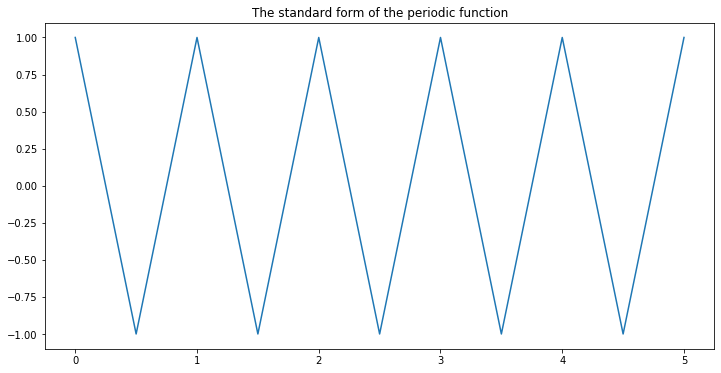

In [12]:
def f(x, A=1, lambd=1, phi=0, sigma=0):
    '''
    A periodic triangle function with specified amplitude, frequency, phase,
    and optional noise added to the function value.

    Inputs:

        x (float or array): The input value(s) at which to evaluate the
          function.

        A (float): The amplitude of the function. The non-noisy function
          value will vary from -A to A. Default: 1.

        lambda (float): The frequency of the function. There will will be
          lambda waves per unit of `x`. Default: 1.

        phi (float): The phase offset of the function. The graph of the
          function moves to the left by this many waves. Note that `phi`
          is periodic in the range [0, 1], so setting `phi = 1.2` will
          have the same effect as setting `phi = 0.2` or `phi = `2.2`.
          Default: 0.

        sigma (float): The amount of noise to add to the function value,
          interpreted as the standard deviation of zero-mean Gaussian
          noise. Default: 0.

    Returns: (float or array) matching the dimensions of `x` with the
      periodic function values.
    '''
    return (
        A * (4 * abs((lambd * x + phi) % 1 - 0.5) - 1) +
        stats.norm.rvs(0, sigma, size=np.shape(x)))

plot_x = np.linspace(0, 5, 501)
plt.figure(figsize=(12, 6))
plt.plot(plot_x, f(plot_x))
plt.title('The standard form of the periodic function')
plt.show()

## Data set for Stan

We generate data that is a noisy version of the periodic function. We use the following parameters—

* Amplitude: $A = 2$
* Frequency: $\lambda = \frac{1}{21.1}$
* Phase: $\phi = 0.33$
* Noise: $\sigma = 0.5$

We generate 200 values and use the first 100 as data for computing posterior distributions over the parameters above using Stan. We use the second 100 values to test our prediction of future function values.

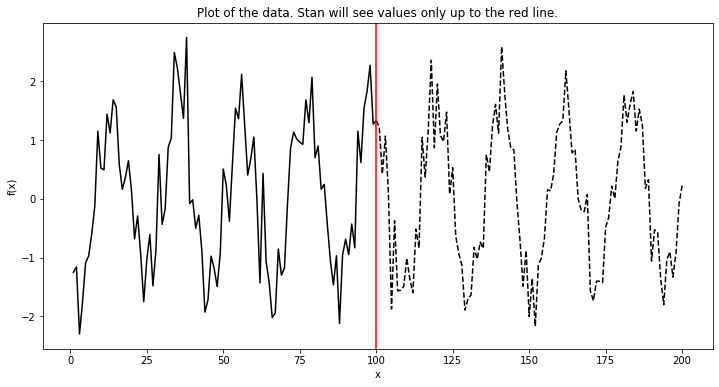

In [13]:
# The true parameters, which Stan will try to estimate
A = 2           # Amplitude
lambd = 1/21.1  # Frequency
phi = 0.33      # Phase
sigma = 0.5     # Noise

# Generate data - a noisy version of the triangular wave above. We generate
# 100 observed data for computing posteriors and will also use Stan to
# predict the values of the next 100 data points.
n = 100
n_future = 100
data = f(
    np.arange(1, n + n_future + 1),
    A=A, lambd=lambd, phi=phi, sigma=sigma)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, n + 1), data[:n], 'k-')
plt.plot(np.arange(n, n + n_future + 1), data[n-1:], 'k--')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Plot of the data. Stan will see values only up to the red line.')
plt.axvline(n, color='red')
plt.show()

## Stan model

### Constrained parameters in Stan

Since this is a periodic function, we need to be careful to provide the correct constraints on the parameters $A$, $\lambda$, $\phi$, $\sigma$. If we get the constraints wrong we will have multiple modes with exactly the same meaning in the posterior — and you have already seen that MCMC methods do not like unnecessary extra modes.

In the Stan model below, the amplitude $A$ is constrained to be positive. This is because a negative amplitude flips the function around the horizontal axis, which is equivalent to adding 0.5 to the phase. See the plot below.

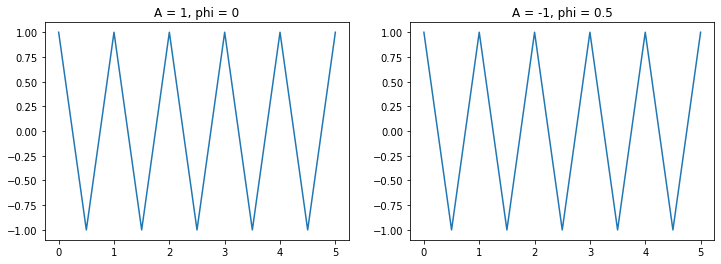

In [14]:
plot_x = np.linspace(0, 5, 501)
plt.figure(figsize=(12, 4))

for i, (A, phi) in enumerate([(1, 0), (-1, 0.5)]):
    plt.subplot(1, 2, i + 1)
    plt.plot(plot_x, f(plot_x, A=A, phi=phi))
    plt.title(f'A = {A}, phi = {phi}')

plt.show()

We have another constraint, namely that the phase $\phi$ is periodic in the range $[0,1]$. So a value of $\phi = 1.2$ is equivalent to a value of $\phi = 0.2$ or $\phi = 3.2$. The fractional part, 0.2, is all that matters. To avoid multiple modes due to this periodicity we have to constrain $\phi$ to the range [0,1] but in a way that makes it periodic, so that Stan knows $\phi=0$ is equivalent to $\phi=1$.

We achieve this periodic constraint by transforming two new parameters $\phi_x$ and $\phi_y$ into $\phi$ using the arctan function.

##  Task 1
Use the Stan model code below to figure out how the periodic constraint on the $\phi$ parameter is implemented.

The atan2 function returns a value in the range [-pi, pi], which we then transform linearly into the range [0, 1].

In [15]:
# The Stan model. Running this cell compiles the Stan model, which takes
# some time.

stan_data = {
    'n': n,
    'n_future': n_future,
    'x': data[:n]}  # Stan gets to see the first n data values only

stan_code = """
data {
    int<lower=0> n;        // The number of data
    real x[n];             // The data
    int<lower=0> n_future; // The number of future values to predict
}

parameters {
    real<lower=0> A;
    real<lower=0> lambda;
    real<lower=0> sigma;

    // We need a periodic phi
    real phi_x;
    real phi_y;
}

transformed parameters {
    real<lower=0,upper=1> phi;

    // The atan2 function returns a value in the range [-pi, pi], which we
    // then transform linearly into the range [0, 1].
    phi = atan2(phi_x, phi_y) / (2 * pi()) + 0.5;
}

model {
    A ~ normal(0, 5);
    phi_x ~ normal(0, 1);
    phi_y ~ normal(0, 1);
    sigma ~ gamma(1, 0.3);
    for(t in 1:n) {
        x[t] ~ normal(
            A * (4 * fabs(fmod(lambda * t + phi, 1) - 0.5) - 1),
            sigma);
    }
}

// Generate the predicted function values for the next n_future steps.
generated quantities {
    real x_future[n_future];
    for(t in 1:n_future) {
        x_future[t] = normal_rng(
            A * (4 * fabs(fmod(lambda * (t + n) + phi, 1) - 0.5) - 1),
            sigma);
    }
}
"""

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_299aa46eac284b1ecd4d5dda095fa602 NOW.


## Task 2
After running the code below, comment on the Stan output.
 1. Use the Rhat value to comment on whether the Markov chains converged properly or not. Explain your answer.
 2. What are the total number of samples and the effective number of samples? Are these values good or not?
 
 
No, rhat is high (lowest is 1.68) and neff is low (2/3)

In [16]:
# Run Hamiltonian Monte Carlo using Stan with 4 Markov chains, a 1000 step
# warm-up phase and 1000 step sampling phase for each chain. The warm-up samples
# are discarded, so we are left with 4 x 1000 = 4000 samples.

# This cell will take a minute or two to run.

parameters = ['A', 'lambda', 'phi', 'sigma']

results = stan_model.sampling(data=stan_data)
print(results.stansummary(pars=parameters))
samples = results.extract()

Inference for Stan model: anon_model_299aa46eac284b1ecd4d5dda095fa602.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
A        1.87  1.9e-3   0.09    1.7   1.81   1.87   1.93   2.04   2187    1.0
lambda   3.95     1.5   2.12   1.95   1.95   3.45   6.05   6.95      2 9761.2
phi      0.66  3.5e-4   0.01   0.63   0.65   0.66   0.66   0.68   1496    1.0
sigma    0.52  3.1e-3   0.04   0.45   0.49   0.52   0.54    0.6    158   1.03

Samples were drawn using NUTS at Sat Dec 14 21:14:18 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## Task 3
Run the code below and use the plots to answer the following questions.

 1. Are the samples correlated or reasonably independent?
 2. What information does the pair plot provide?
 
 Extremely correlated

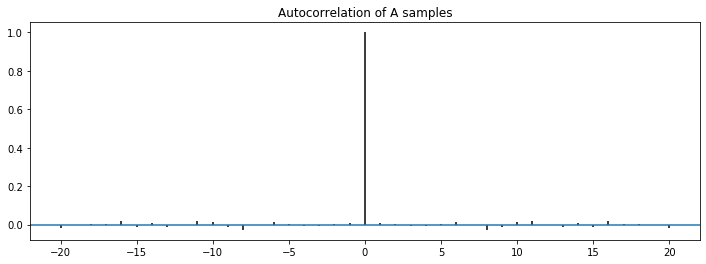

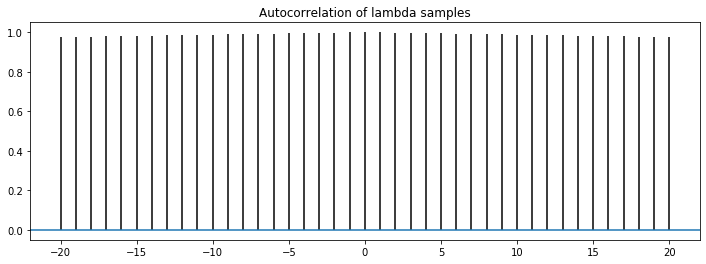

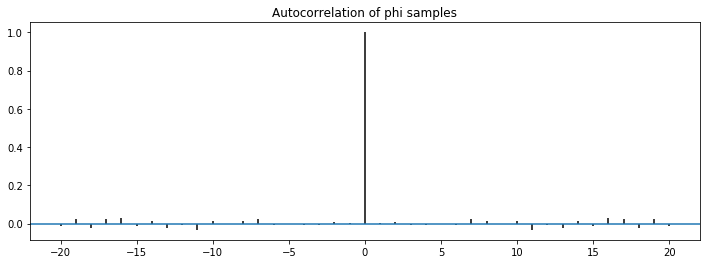

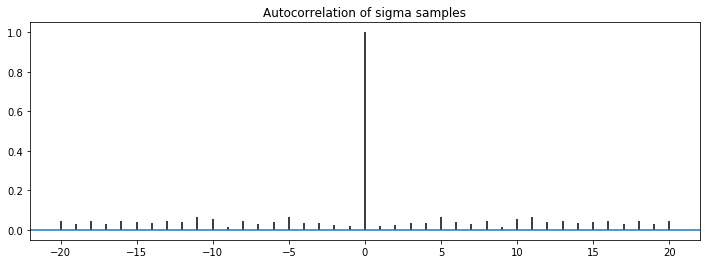

In [17]:
# Plot sample autocorrelation for each parameter.

def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))


for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

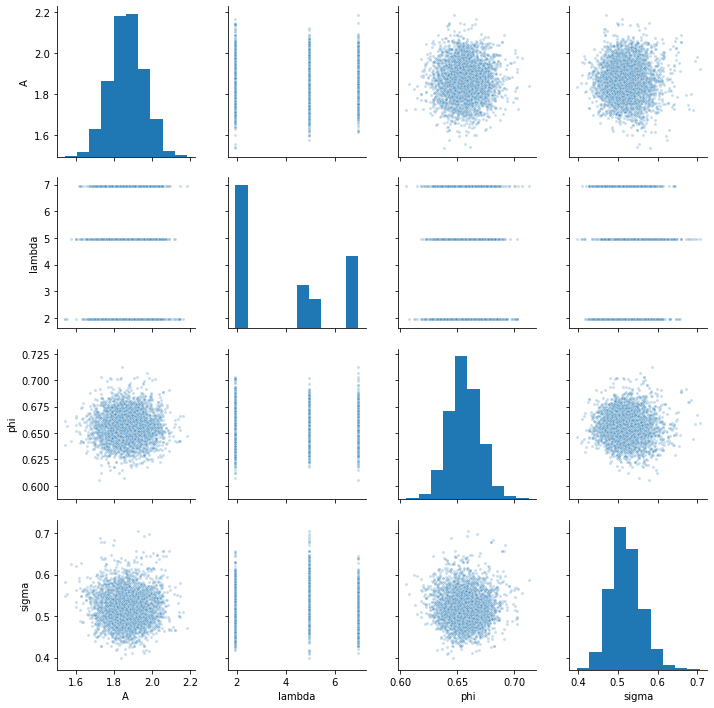

In [18]:
# Make pair plot of the posteriors over all parameters of the model.
df = pandas.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

## Prediction of future values

Finally, we use the generated `x_future` samples from Stan to show the 95% confidence interval of the predicted future values of the periodic function.

## Task 4
Does the predictive 95% interval look good or not?

No? It's really wide.

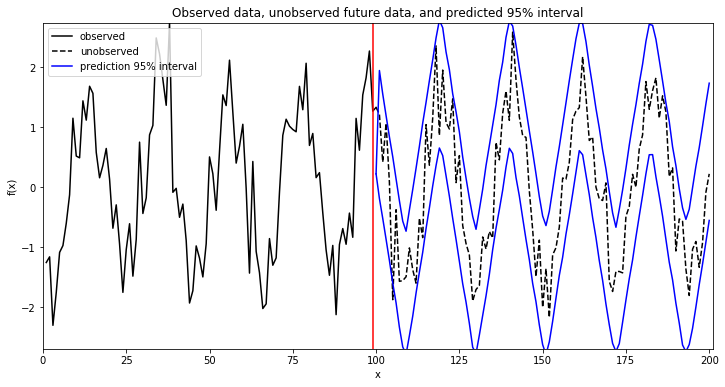

In [19]:
prediction = samples['x_future']

# Compute 95% interval of the predicted values
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])

# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))
plt.plot(range(1, n + 1), data[:n], 'k-', label='observed')
plt.plot(range(n, n + n_future + 1), data[n-1:], 'k--', label='unobserved')
plt.xlim(0, n + n_future + 1)
plt.ylim(
    min(min(prediction[0,:]), min(data)),
    max(max(prediction[1,:]), max(data)))
plt.plot(
    range(n, n + n_future + 1),
    np.concatenate((data[-1:], prediction_interval[0,:])),
    'b-', label='prediction 95% interval')
plt.plot(
    range(n, n + n_future + 1),
    np.concatenate((data[-1:], prediction_interval[1,:])),
    'b-')
plt.axvline(n - 1, color='red')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.title('Observed data, unobserved future data, and predicted 95% interval')
plt.show()

In [20]:
data

array([-1.25394144e+00, -1.15934733e+00, -2.30119647e+00, -1.74978641e+00,
       -1.08487614e+00, -9.71252333e-01, -5.98678932e-01, -1.24535416e-01,
        1.15181792e+00,  5.20685272e-01,  4.91527873e-01,  1.44152260e+00,
        1.12014690e+00,  1.68488718e+00,  1.56687665e+00,  5.81503892e-01,
        1.58613071e-01,  3.65491869e-01,  6.47413446e-01,  1.36026015e-01,
       -6.82262431e-01, -2.92845575e-01, -9.45958944e-01, -1.75169897e+00,
       -1.03806743e+00, -6.07393578e-01, -1.48140203e+00, -8.67906163e-01,
        7.53121956e-01, -4.36290343e-01, -1.75653887e-01,  8.74700468e-01,
        1.03240078e+00,  2.49073808e+00,  2.22411254e+00,  1.79706499e+00,
        1.36747914e+00,  2.74555325e+00, -8.30236078e-02, -1.72704218e-02,
       -5.00094647e-01, -2.79743411e-01, -8.88201394e-01, -1.92917595e+00,
       -1.72442010e+00, -9.77188071e-01, -1.18168941e+00, -1.49425888e+00,
       -9.41221715e-01,  5.06832525e-01,  2.26692879e-01, -3.82715886e-01,
        6.01457824e-01,  